In [1]:
import os
import sys
sys.path.append("./../")
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pandas as pd
import yaml
import h5py
import vicon_imu_data_process.process_landing_data as pro_rd
import estimation_assessment.scores as es_as

import seaborn as sns
import copy
import re
import json

from vicon_imu_data_process.const import FEATURES_FIELDS, LABELS_FIELDS, DATA_PATH
from vicon_imu_data_process.const import DROPLANDING_PERIOD, RESULTS_PATH
from vicon_imu_data_process import const
from vicon_imu_data_process.dataset import *

from estimation_models.rnn_models import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import time as localtimepkg

from estimation_study import *
from estimation_assessment.visualization import *
#import pdb
import re

tensorflow version: 2.5.0
tensorflow version: 2.5.0
[LogicalDevice(name='/device:CPU:0', device_type='CPU')] [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


# statistical analysis
## barplot
## fitness plot

1. Three different methods
    - baseline
    - fine-tuning
    - imu augmentation
    - domain adversarial 
    - normal augmentation
    
    Combination multiple dataet to get better results
    
 Using different subjects 



In [2]:
# baseline
fliters={'drop_value':0.2,'sort_variable':'r2'}
combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","investigation_10trials_baseline","10trials_baseline_v"+str(idx),"testing_result_folders.txt") for idx in range(2,7)
                                    ] +[
    os.path.join(RESULTS_PATH, "training_testing","investigation_10trials_finetuning","10trials_finetuning_v"+str(idx),"testing_result_folders.txt") for idx in range(2,4)
                                    ] + [
    os.path.join(RESULTS_PATH, "training_testing","investigation_10trials_imu_augment","10trials_imu_augment_v"+str(idx),"testing_result_folders.txt") for idx in range(2,7)
                                    ] 

        
'''     
        + [
    os.path.join(RESULTS_PATH, "training_testing","investigation_5trials_normal_dann","5trials_normal_dann_v"+str(idx),"testing_result_folders.txt") for idx in range(2,7)
                                    ] + [
    os.path.join(RESULTS_PATH, "training_testing","investigation_5trials_repeated_dann","5trials_repeated_dann_v"+str(idx),"testing_result_folders.txt") for idx in range(2,7)
                                    ] + [
    os.path.join(RESULTS_PATH, "training_testing","investigation_5trials_augment_dann","5trials_augment_dann_v"+str(idx),"testing_result_folders.txt") for idx in range(2,7)
                                    ]

'''

#fliters={'drop_value':0.2,'sort_variable':'r2'}
#combination_investigation_results = [
#    os.path.join(RESULTS_PATH, "training_testing","investigation_5trials_repeated_dann","5trials_repeated_dann_v"+str(idx),"testing_result_folders.txt") for idx in range(2,7)
#                                    ]

metrics = get_list_investigation_metrics(combination_investigation_results[3:])
combination_investigation_metrics = [os.path.join(os.path.dirname(folder),"metrics.csv") for folder in combination_investigation_results]
metrics = get_list_investigation_metrics(combination_investigation_metrics)

subs = list(set(metrics['alias_name']))
replace_values = {sub: int(sub.split('v')[1])-1 for sub in subs}

replace_values.update({'baseline': 'Baseline', 'finetuning': 'Fine-tuning', 'imu_augment': 'IMU augmentation', 'Normal_DANN': 'DANN', 'DANN': 'TDANN', 'Aug_DANN': 'ADANN'})
print(replace_values)

plot_config={
    "save_fig": False, "save_format":"jpg", "save_folder_index": 0,
    'figsize':(8, 5),
    "hue": 'model_selection',
    'replace_values': replace_values,
    'replace_columns': {'alias_name': 'Train subject number'},
    'x': 'Train subject number',
    'title': 'baseline',
    'ykicks': (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
    #'plot_title': 'baseline',
    'font_scale': 1.2
}

p6plot_model_accuracy(combination_investigation_metrics,fliters, ttest=False, **plot_config)



/home/sun/drop_landing_workspace/results/training_testing/investigation_10trials_baseline/10trials_baseline_v5/testing_result_folders.txt
/home/sun/drop_landing_workspace/results/training_testing/investigation_10trials_baseline/10trials_baseline_v6/testing_result_folders.txt
/home/sun/drop_landing_workspace/results/training_testing/investigation_10trials_finetuning/10trials_finetuning_v2/testing_result_folders.txt
/home/sun/drop_landing_workspace/results/training_testing/investigation_10trials_finetuning/10trials_finetuning_v3/testing_result_folders.txt


FileNotFoundError: [Errno 2] No such file or directory: '/home/sun/drop_landing_workspace/results/training_testing/investigation_10trials_finetuning/10trials_finetuning_v3/testing_result_folders.txt'

## Fig.1 Estimation accuracy of KFM during double-leg drop landing using five different methods: Basline, fine-tuning, IMU augmentation, DANN, and TDANN. 

## Estimation of biomechanical variables is promising 


Biomechanical variable estimation is promisingly useful in varied fields, including motion risk prevention, intervention training program, and exoskeleton robots. The estimation of various biomechanical variables, such as loading rate, ground reaction force, hip, and knee angles, and moments during walking and running, have been investigated using machine learning algorithms and wearable senors. To train the data-driven models with labeled dataset, lots of biomechanical experiments in many standard biomechanical labs have been performed to collect the target variable and wearable sneosr values. The data collection is complex and time-cost since the experiments need multiple expensive equipments (e.g., optical motion capture system, force plate, or split-treadmill with force plates) and complex procedure and operations. Collecting the sufficient dataset is a huge barrier to train a new data-driven model with accurate estimation.

The estimation performance of knee extension moment (KEM) during drop landing tasks still has a strong demand for improvement. Unlike periodic walking and running movements, drop landing is characterized by large, non-periodic, and short-term impacts. These features require the drop landing estimation models with deep structure to map the complicated non-linear relationship between target variable and wearable sensor values. The training of the deep data-driven model requires a large dataset. However, collecting necessary data by landing-task trials is more time-consuming and difficult. This is because each trial (landing from a box) of landing has to be performed one by one discretely, in contrast to the walking and runing where massive trials (strides) can be performed during a continued walking or running process. Moreover, the landing trials have an obvious ligament injury risk rathen than stepping for participants because landing movement normally induces several times the body weight on the legs. Thus, it is unacceptable to ask a subject to perform too many times landing in an experiment. Getting more landings trials, a way is to recruit more subjects. This cause more difficult in landing data collection.








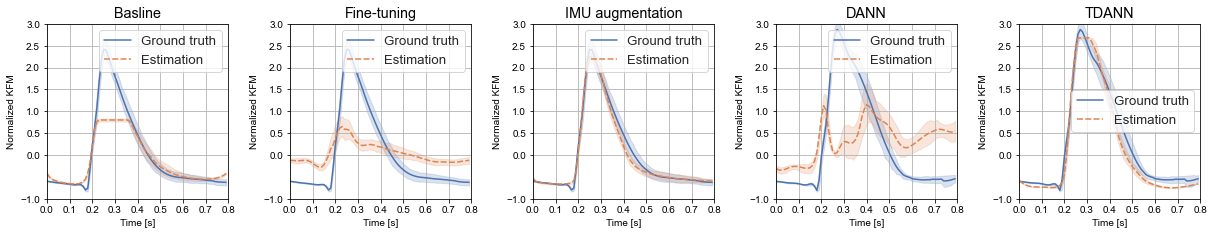

In [2]:
# Plot estimation results

combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","investigation_5trials_baseline","5trials_baseline_v"+str(idx),"testing_result_folders.txt") for idx in range(6,7)
                                    ] +[
    os.path.join(RESULTS_PATH, "training_testing","investigation_5trials_finetuning","5trials_finetuning_v"+str(idx),"testing_result_folders.txt") for idx in range(6,7)
                                    ] +[
    os.path.join(RESULTS_PATH, "training_testing","investigation_5trials_imu_augment","5trials_imu_augment_v"+str(idx),"testing_result_folders.txt") for idx in range(6,7)
                                    ] + [
    os.path.join(RESULTS_PATH, "training_testing","investigation_5trials_normal_dann","5trials_normal_dann_v"+str(idx),"testing_result_folders.txt") for idx in range(6,7)
                                    ] + [
    os.path.join(RESULTS_PATH, "training_testing","investigation_5trials_repeated_dann","5trials_repeated_dann_v"+str(idx),"testing_result_folders.txt") for idx in range(6,7)
                                    ]
config = {
  'xticks':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
  'yticks':[-1.0, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
  'figsize': (18,3),
  'ylabels': 5*['Normalized KFM'],
   'titles': ['Basline', 'Fine-tuning', 'IMU augmentation', 'DANN', 'TDANN'],
  'font_scale':1.2,  
}

figpath, multi_model_results = p6plot_statistic_actual_estimation_curves(combination_investigation_results, col_wrap=5, **config)

## Baselien

## Augmentation

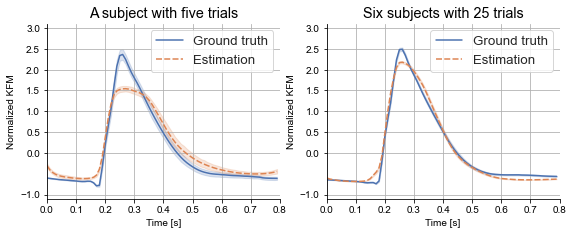

/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v1/5trials/5sub/data_visulization/2022-10-09/13_31_35_curves..svg


In [2]:
# Plot estimation results of augmentation

combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","investigation_imu_augment_v1",str(trial_idx)+"trials",str(sub_idx)+"sub","testing_result_folders.txt") for sub_idx in [5] for trial_idx in [5]
                                    ] +[
    os.path.join(RESULTS_PATH, "training_testing","investigation_imu_augment_v1",str(trial_idx)+"trials",str(sub_idx)+"sub","testing_result_folders.txt") for sub_idx in [10] for trial_idx in [25]
                                ]
config = {
  'xticks':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
  'yticks':[-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    'ylim':[-1.0, 3.0],
  'figsize': (8,3),
  'ylabels': 5*['Normalized KFM'],
   'titles': ['A subject with five trials', 'Six subjects with 25 trials'],
  'font_scale':1.2, 
   'save_fig': True,
    'save_format': '.svg'
}

figpath, multi_model_results = p6plot_statistic_actual_estimation_curves(combination_investigation_results, col_wrap=2, **config)

/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v1/5trials/5sub/metrics.csv
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v1/10trials/5sub/metrics.csv
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v1/15trials/5sub/metrics.csv
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v1/20trials/5sub/metrics.csv
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v1/25trials/5sub/metrics.csv
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v1/5trials/6sub/metrics.csv
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v1/10trials/6sub/metrics.csv
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v1/15trials/6sub/metrics.csv
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v1/20trials/6s

Text(0.5, 16.0, 'Trial number')

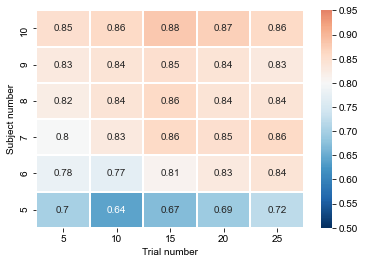

In [21]:
# imu augmentation
combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","investigation_imu_augment_v1",str(trial_idx)+"trials",str(sub_idx)+"sub","testing_result_folders.txt") for sub_idx in range(5,11,1) for trial_idx in range(5,26,5)
                                    ]
combination_investigation_metrics = [os.path.join(os.path.dirname(folder),"metrics.csv") for folder in combination_investigation_results]
filters={'drop_value':0.0,'sort_variable':'r2'}
filters={}

aug_metrics = parase_list_investigation_metrics(combination_investigation_metrics,**filters)
aug_metrics.shape
data = aug_metrics[['trial_num','subject_num','r2']].groupby(['subject_num','trial_num']).mean().round(2).reset_index().pivot('subject_num','trial_num')['r2']
ax = sns.heatmap(data, vmin=0.5, vmax=0.95,cmap="RdBu_r",center=0.8,annot=True,linewidths=0.3).invert_yaxis()
plt.ylabel('Subject number')
plt.xlabel('Trial number')


In [19]:
aug_metrics[['trial_num','subject_num','r2']][aug_metrics['trial_num'].isin([5,10])].groupby(['subject_num','trial_num']).describe().round(2)['r2'][['min','50%', '75%','max']].T

subject_num    5           6           7           8           9           10  \
trial_num      5     10    5     10    5     10    5     10    5     10    5    
min          0.10 -3.87  0.05 -1.35 -0.24 -0.17  0.20  0.02  0.33 -0.13  0.30   
50%          0.76  0.78  0.84  0.85  0.86  0.87  0.86  0.86  0.87  0.88  0.91   
75%          0.83  0.84  0.90  0.92  0.92  0.94  0.94  0.94  0.94  0.93  0.95   
max          0.94  0.95  0.97  0.99  0.98  0.99  0.98  0.99  0.98  0.98  0.99   

subject_num        
trial_num      10  
min         -0.02  
50%          0.92  
75%          0.95  
max          0.99